## Classify SNP counts for mixed germline samples

### Problem Statement
The objective is to write software that classifies SNP counts for mixed germline samples (a minority sample mixed with a majority sample, e.g., through a contamination mechanism) and estimates the fraction of the minority sample. 

Despite counting and sequencing noise terms (and others), a best estimate of the minority sample fraction can be calculated across all alleles. 

The objective is then to identify which SNPs are likely to be informative (i.e., not matching the majority allele pattern) and calculate the minority sample fraction (MSF).

### Output
The output shall be two csv's. 

The first has three columns with one row per input file per SNP: column one contains the input file names, the second column contains the SNP ID, and the third is a flag as to whether or not that SNP is informative as defined above. 

The second csv has three columns with one row per input file: column one contains the input file names, and the second column contains the estimated minority sample fraction, and the third column is the uncertainty in that fraction.

In [1]:
import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
today_date = datetime.date.today()
print(today_date) # created files should have the current date, so you can find errors.  time is also helpful
# I was thining about using the string in file name, and decided against it
my_str = "hw_sample*"
newstr = my_str.replace("*", "")
print(newstr)

2020-02-14
hw_sample


In [3]:
filenames = glob.glob('hw_sample*') # first import any number of files
print(filenames)
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in filenames ], sort = True)
# this works, but does not do error handling
# "new" columns added without comment
# extra columns added if present

combined_csv.allele.unique() 

['hw_sample_1.csv', 'hw_sample_0.csv', 'hw_sample_2.csv', 'hw_sample_7.csv', 'hw_sample_6.csv', 'hw_sample_4.csv', 'hw_sample_5.csv']


array(['A', 'R', 'B', nan], dtype=object)

In [4]:
combined_csv.head()
# remember to add file name

,allele,allele1,count,dbSNP.ID,test
0,A,NaN,113,rs10031144,NaN
1,R,NaN,162,rs10031144,NaN
2,R,NaN,336,rs10044327,NaN
3,A,NaN,353,rs10044327,NaN
4,A,NaN,55,rs10829589,NaN


In [5]:
def combine_files(search_text):
    combined_file = pd.DataFrame() # create empty data frame
    filenames = glob.glob(search_text) # first import any number of files
    if len(filenames) == 0: # if the file is blank, let people know
        print("no files")
        print("no file created")
        exit(2) # end the program (this will exit python) fail fast!
    else: 
        true_columns = sorted(['dbSNP.ID', 'allele', 'count' ]) # We know the true columns
        for file in filenames:
            test_file = pd.read_csv(file)
            column_list = sorted(list(test_file.columns.values))
            if len(column_list) == 3: # if there are three columns
                if true_columns == column_list: # if they match true headers
                    true_allele = sorted(['A', 'R'])
                    if true_allele == sorted(list(test_file.allele.unique())):
                        test_file['FileName'] = file # add the file name as a column
                        try:
                            # test if the count column really is numbers
                            test_file['count'] = test_file['count'].astype(float)
                            
                            combined_file = combined_file.append(test_file,ignore_index=True) 
                            print(file, "file added") # this may be impractical if there are hundreds of files
                        except ValueError:
                            print(file, "count column includes non-numbers")
                        
                    else:
                        print(file, "wrong allele list", test_file.allele.unique())
                        # Another source of error could be that the file was set up wrong.  
                        # This is only one way it could be wrong.  Another could be in SNP name and Count NaN
                else:
                    print(file, "columns do not match", column_list)
            else:
                print(file, "too many columns", column_list)
        #export to csv
        new_file_name = str(datetime.date.today()) + "_combined_file.csv"
        combined_file.to_csv(new_file_name, index=False) # save the file before doing calculations
        print(new_file_name," file created")
    return(combined_file)

In [6]:
file1 = combine_files('hw_sample*')

hw_sample_1.csv file added
hw_sample_0.csv file added
hw_sample_2.csv file added
hw_sample_7.csv count column includes non-numbers
hw_sample_6.csv wrong allele list ['B' 'R']
hw_sample_4.csv too many columns ['allele1', 'count', 'dbSNP.ID', 'test']
hw_sample_5.csv columns do not match ['allele1', 'count', 'dbSNP.ID']
2020-02-14combined_file.csv  file created


In [7]:
def label_informative(data_frame):
    # spread the columns (make the two alleles each their own column)
    stacked_file = data_frame.pivot_table(index=['dbSNP.ID', 'FileName'], columns='allele', values='count') 
    stacked_file = stacked_file.reset_index() # I don't like working with two columns as "index"
    stacked_file = stacked_file.fillna(0) # if either A or R had no values, we fill them with zero
    # caluclate the frequency of A allele, R is not needed as freq_A + freq_R = 1
    stacked_file['freq_A'] = stacked_file['A']/(stacked_file['R']+ stacked_file['A'])
    # we want those with low A and with low R.  Subtracting freq_A from 0.5 gets us low A
    # using the absolute value (abs) gives us both low R and low A
    stacked_file['abs_A'] = abs(stacked_file['freq_A'] - 0.5)
    # we want to label those with frequency (A or R) > 0.8 as informative
    stacked_file.loc[stacked_file.abs_A > 0.3, 'informative'] = 'True' 
    stacked_file.loc[stacked_file.abs_A <= 0.3, 'informative'] = 'False' 
    # there are some SNP's with very low counts, possibly due to read error
    # I chose to ignore those with counts less than 2% as uninformative
    stacked_file.loc[stacked_file.abs_A > 0.48, 'informative'] = 'False'
    new_file_name = str(datetime.date.today()) + "_labels_output_1.csv"
    # the exercise said to create a file with orig file name, SNP and informative-ness
    output_1 = stacked_file[['FileName','dbSNP.ID', 'informative' ]]
    output_1.to_csv(new_file_name, index = False)
    print(new_file_name," file created")
    return(stacked_file)

In [8]:
test1 = label_informative(file1)
test1.head()

2020-02-14_labels_output_1.csv  file created
['dbSNP.ID', 'FileName', 'A', 'R', 'freq_A', 'abs_A', 'informative']


allele,dbSNP.ID,FileName,A,R,freq_A,abs_A,informative
0,rs10031144,hw_sample_0.csv,63.0,85.0,0.425676,0.074324,False
1,rs10031144,hw_sample_1.csv,113.0,162.0,0.410909,0.089091,False
2,rs10031144,hw_sample_2.csv,99.0,112.0,0.469194,0.030806,False
3,rs10044327,hw_sample_0.csv,241.0,260.0,0.481038,0.018962,False
4,rs10044327,hw_sample_1.csv,353.0,336.0,0.512337,0.012337,False


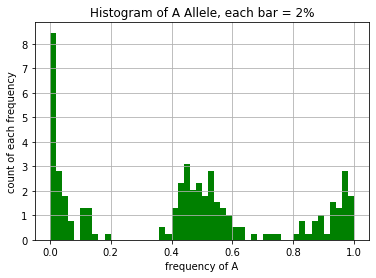

In [9]:
plt.hist(test1['freq_A'], 50, density=True, facecolor='g')
plt.xlabel('frequency of A')
plt.ylabel('count of each frequency')
plt.title('Histogram of A Allele, each bar = 2%')
plt.grid(True)
plt.show()

### Comments on data distribution
In the histogram above there are three populations, those homologous for allele A, those homologous for allele R, and those heterlogous for both alleles.   The population that is homologous for R (frequency of A < 20%) has very little contamination (35 SNPs with <2% contamination). The SNPs with <2% contamination could be due to counting and sequencing noise.  I decided to remove those from the minority sample fraction. The population that is heterlogous for both alleles is the center group (frequency 0.36-0.76). If we are looking at contamination, we want to look at those alleles with majority homologous for either allele.  In this dataset a clear cut off could be applied at 80% and 20%.  With a larger dataset, this cut off may not work, especially if the contamination increases beyond 20%.

In [10]:
# minority sample fraction = MSF
def find_MSF(data_frame):
    contam_data = data_frame.loc[data_frame['informative'] == 'True'].copy()
    contam_data['MSF'] = abs(contam_data['abs_A'] - 0.5)
    # uncertanty can be a measure of the error around the mean.  
    # I am chosing standard deviation (std) and standard error (sem).
    minor_sample_fraction = contam_data.groupby(['FileName'], as_index = False).agg(
        {'MSF': ['mean', 'count','std', 'sem']})
    new_file_name = str(datetime.date.today()) + "MSF_output2.csv"
    minor_sample_fraction.to_csv(new_file_name, index = False) # save the file before doing calculations
    return(minor_sample_fraction)    

In [11]:
test2 = find_MSF(test1)
test2

[('FileName', ''), ('MSF', 'mean'), ('MSF', 'count'), ('MSF', 'std'), ('MSF', 'sem')]


FileName       MSF                          
                        mean count       std       sem
0  hw_sample_0.csv  0.049034    16  0.023410  0.005852
1  hw_sample_1.csv  0.075821    27  0.046313  0.008913
2  hw_sample_2.csv  0.092295    25  0.053442  0.010688

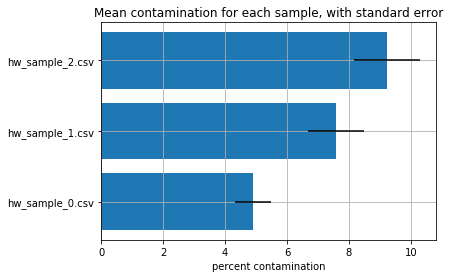

In [12]:
plt.barh(test2['FileName'], 100* test2[('MSF', 'mean')], xerr=100*test2[('MSF', 'sem')], align='center')
plt.xlabel('percent contamination')
#plt.ylabel('sample name')
plt.title('Mean contamination for each sample, with standard error')
plt.grid(True)
plt.show()


### Changes to production code
This code is fairly bare bones.  In real code, the raw sample files and the completed analysis files don't belong in the same folder.  It would be fairly easy to add this, and even have the python code create a directory for the completed analysis files.

With more input from the automation team, and from the assay team I could add more realistic methods for error handling.  For example, perhaps the sample with wrong allele values is a human error, and we can change the allele value (not the count) after importing the file.  I would also look into why Sample_2 has so much contamination, and how we can replicate the low contamination in Sample_0.  I would focus on the good results of Sample_0, and try to discover what human differences might have caused it.

1) NIPT: assume that the minority fraction sample is related to the majority sample as in the
case of fetal DNA in a maternal background. How do your assumptions about the fetal
fraction calculation change from the contamination case?
2) Oncology: assume that the minority fraction sample is derived from germline in the form of
heterogeneous tumor DNA (say after relapse) in a germline cell-free DNA background.
3) If your implementation was more bare-bones, how would you identify and test more robust
software solutions that could be implemented in production code in a regulated
environment? If assay/target improvements are desired, what would you ask for from the
assay team?

## Conclusions
Here we calculated the percent contamination to be less than 10% for all samples.  Sample_0 had the least contamination (5%), and Sample_2 had the most contamination (9%).  

When looking at the raw data, three SNPs were not informative for Sample_2 (rs12492157, rs4855031, and rs965308), but were informative for the other samples.  These SNPs were all slightly more than 20% R allele.  They could be contamination, which would increase the contamination for Sample_2.  This is a case where contamination may be more than 10%, which shows up in these outlier samples.  Adjusting the cutoff could imporve this number.

If we are looking for the fetal fraction of the sample, I would look at the variability in counts of the heterozygous alleles.  The fetal fraction could be moving those samples away from 50%.  This could indicate fetal genes that are different from the parent.   I would also highlight those samples in Sample_2 that were 20-30% minority sample.  This could be driven by the mother being homologous for the SNP, and the child being heterlogous for the SNP.

If we are looking for samples of tumor DNA, I would weight the SNPs that are known to have some cancer activity.  I would also look for SNPs that were present during the initial treatment, to see if they return after relapse.  
